In [90]:
%reset

# Football Predict
## Questions before start:
We have a bunch of csv files, where each one is divided into categories:
1. Country (belgium, england, france, germany, greece, italy, netherlands, portugal, scotland, spain, turkey)
2. League (0, 1, 2, 3)
3. Season (2000-2001, 2001-2002, ..., 2021-2022)

Should we merge all the csv files into one big dataframe? Or should we keep them separate? 
If we merge them, how do we keep track of the different leagues and seasons?  

## Thoughts:
We could merge them into one big dataframe, and provide analysis on the whole dataset. 
In case we need analyse a specific league or season, we can filter the dataframe accordingly.

**Before merging**, we should add a column for the league and season.


In [91]:
# TODO: 
#  1. try to find in what city match occurred (add as feature), and find related weather data for that city and day (as feature)
#  (DONE) 2. check if particular bookmaker appears only in one (or more) country 
#  (DONE) 3. check if particular bookmaker appears only in one (or more) league
#  (DONE) 4. add weekend/weekday as feature (as "Betting odds for weekend games are collected Friday afternoons, and on Tuesday afternoons for midweek games.")
#  5. add "number of days since last match" as feature
#  (DONE) 6. check correlations in odds across bookmakers, so that we can drop some columns (probably keep only one bookmaker)
#  7. Aggregated columns for bookmakers odds, (min, max, median, mean odd from bookmakers, make column with Interwetten + other so we don't have missing values).
#  8. see case study notebook for more ideas
#  9. split teams by name
#  10. statistical features based on previous matches (e.g. average goals scored in last 5 matches, average goals conceded in last 5 matches, etc.)
#  11. construct dataframe with all countries, split by league
#  12. input NAs (mean average)
#  13. Modeling: classification – Random Forest, Logistic Regression, SVM
#                regression – Random Forest, Linear Regression, Stepwise Regression, SVM
#  14. Compare models classification: by accuracy, precision, recall, F1 score, ROC curve, AUC
#                     regression: by RMSE, R2, MAE  




In [92]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [93]:
# csv_files = sorted(glob(f'data/train/**/*.csv', recursive=True))

def read_data(folder_path, mac=False):
    df = pd.DataFrame()
    separator = '/' if mac else '\\'

    for file_path in sorted(glob(f'{folder_path}{separator}**{separator}*.csv', recursive=True)):
        csv_file_df = pd.read_csv(file_path)

        # Rename HT and AT columns to HomeTeam and AwayTeam
        if 'HT' in csv_file_df.columns or 'AT' in csv_file_df.columns:
            csv_file_df.rename(columns={'HT': 'HomeTeam', 'AT': 'AwayTeam'}, inplace=True)

        # Extract country, league, and season from file path
        parts = file_path.split(separator)
        country = parts[-3]
        league = parts[-2]
        season = parts[-1].split('.')[0]

        # Add country, league, and season as features to the front
        csv_file_df.insert(0, 'Country', country)
        csv_file_df.insert(1, 'League', league)
        csv_file_df.insert(2, 'Season', season)

        # Convert date to datetime format and sort by date
        csv_file_df['Date'] = pd.to_datetime(csv_file_df['Date'], format='%d/%m/%y', errors='ignore')
        csv_file_df['Date'] = pd.to_datetime(csv_file_df['Date'], format='%d/%m/%Y', errors='coerce')
        csv_file_df = csv_file_df.sort_values(by='Date')

        # Determine if the game is on a weekend or weekday
        # Weekends are typically Saturday (5) and Sunday (6)
        csv_file_df['DayOfWeek'] = csv_file_df['Date'].dt.dayofweek
        csv_file_df['Weekend'] = csv_file_df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

        df = pd.concat([df, csv_file_df], ignore_index=True, axis=0, join='outer', sort=False)

    return df

In [94]:
# Read all training data
train_df = read_data('data/train', mac=True)

In [95]:
# Display unique column names and their count
unique_columns = train_df.columns.unique()
column_count = len(unique_columns)

print("Unique Column Names:")
print(unique_columns)

print("\nNumber of Unique Columns:", column_count)

Unique Column Names:
Index(['Country', 'League', 'Season', 'Div', 'Date', 'HomeTeam', 'AwayTeam',
       'FTHG', 'FTAG', 'FTR',
       ...
       'Unnamed: 72', 'LB', 'LB.1', 'LB.2', 'Unnamed: 24', 'Unnamed: 27',
       'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 53', 'Unnamed: 106'],
      dtype='object', length=215)

Number of Unique Columns: 215


In [96]:
# Drop empty columns starting with "Unnamed"
train_df = train_df.filter(regex='^(?!Unnamed).*$')


## Column Dicts

In [97]:
# Split columns into categories about match (results data), Match Statistics, and betting odds (as in notes.txt)
# Rename columns later
match_data = {
    "DayOfWeek": "DayOfWeek",
    "Weekend": "Weekend",
    "League": "League",
    "Season": "Season",
    "Country": "Country",
    "Div": "League_Division",
    "Date": "Match_Date",
    "Time": "Time_of_match_kick_off",
    "HomeTeam": "Home_Team",
    "AwayTeam": "Away_Team",
    "FTHG": "Full_Time_Home_Team_Goals",
    "FTAG": "Full_Time_Away_Team_Goals",
    "FTR": "Full_Time_Result",
    "HTHG": "Half_Time_Home_Team_Goals",
    "HTAG": "Half_Time_Away_Team_Goals",
    "HTR": "Half_Time_Result"
}

match_statistics = {
    "Attendance": "Crowd_Attendance",
    "Referee": "Match_Referee",
    "HS": "Home_Team_Shots",
    "AS": "Away_Team_Shots",
    "HST": "Home_Team_Shots_on_Target",
    "AST": "Away_Team_Shots_on_Target",
    "HHW": "Home_Team_Hit_Woodwork",
    "AHW": "Away_Team_Hit_Woodwork",
    "HC": "Home_Team_Corners",
    "AC": "Away_Team_Corners",
    "HF": "Home_Team_Fouls_Committed",
    "AF": "Away_Team_Fouls_Committed",
    "HFKC": "Home_Team_Free_Kicks_Conceded",
    "AFKC": "Away_Team_Free_Kicks_Conceded",
    "HO": "Home_Team_Offsides",
    "AO": "Away_Team_Offsides",
    "HY": "Home_Team_Yellow_Cards",
    "AY": "Away_Team_Yellow_Cards",
    "HR": "Home_Team_Red_Cards",
    "AR": "Away_Team_Red_Cards",
    "HBP": "Home_Team_Bookings_Points",
    "ABP": "Away_Team_Bookings_Points"
}

betting_odds_1x2_match = {
    "B365H": "Bet365_home_win_odds",
    "B365D": "Bet365_draw_odds",
    "B365A": "Bet365_away_win_odds",
    "BSH": "Blue_Square_home_win_odds",
    "BSD": "Blue_Square_draw_odds",
    "BSA": "Blue_Square_away_win_odds",
    "BWH": "Bet&Win_home_win_odds",
    "BWD": "Bet&Win_draw_odds",
    "BWA": "Bet&Win_away_win_odds",
    "GBH": "Gamebookers_home_win_odds",
    "GBD": "Gamebookers_draw_odds",
    "GBA": "Gamebookers_away_win_odds",
    "IWH": "Interwetten_home_win_odds",
    "IWD": "Interwetten_draw_odds",
    "IWA": "Interwetten_away_win_odds",
    "LBH": "Ladbrokes_home_win_odds",
    "LBD": "Ladbrokes_draw_odds",
    "LBA": "Ladbrokes_away_win_odds",
    "PSH": "Pinnacle_home_win_odds",
    "PSD": "Pinnacle_draw_odds",
    "PSA": "Pinnacle_away_win_odds",
    "SOH": "Sporting_Odds_home_win_odds",
    "SOD": "Sporting_Odds_draw_odds",
    "SOA": "Sporting_Odds_away_win_odds",
    "SBH": "Sportingbet_home_win_odds",
    "SBD": "Sportingbet_draw_odds",
    "SBA": "Sportingbet_away_win_odds",
    "SJH": "Stan_James_home_win_odds",
    "SJD": "Stan_James_draw_odds",
    "SJA": "Stan_James_away_win_odds",
    "SYH": "Stanleybet_home_win_odds",
    "SYD": "Stanleybet_draw_odds",
    "SYA": "Stanleybet_away_win_odds",
    "VCH": "VC_Bet_home_win_odds",
    "VCD": "VC_Bet_draw_odds",
    "VCA": "VC_Bet_away_win_odds",
    "WHH": "William_Hill_home_win_odds",
    "WHD": "William_Hill_draw_odds",
    "WHA": "William_Hill_away_win_odds",
    "Bb1X2": "Number_of_BetBrain_bookmakers_used",
    "BbMxH": "Betbrain_maximum_home_win_odds",
    "BbAvH": "Betbrain_average_home_win_odds",
    "BbMxD": "Betbrain_maximum_draw_odds",
    "BbAvD": "Betbrain_average_draw_win_odds",
    "BbMxA": "Betbrain_maximum_away_win_odds",
    "BbAvA": "Betbrain_average_away_win_odds",
    "MaxH": "Market_maximum_home_win_odds",
    "MaxD": "Market_maximum_draw_win_odds",
    "MaxA": "Market_maximum_away_win_odds",
    "AvgH": "Market_average_home_win_odds",
    "AvgD": "Market_average_draw_win_odds",
    "AvgA": "Market_average_away_win_odds",
}

betting_odds_total_goals = {
    "BbOU": "Number_BetBrain_over_under_2.5_goals_averages_and_maximums",
    "BbMx>2.5": "Betbrain_maximum_over_2.5_goals",
    "BbAv>2.5": "Betbrain_average_over_2.5_goals",
    "BbMx<2.5": "Betbrain_maximum_under_2.5_goals",
    "BbAv<2.5": "Betbrain_average_under_2.5_goals",
    "GB>2.5": "Gamebookers_over_2.5_goals",
    "GB<2.5": "Gamebookers_under_2.5_goals",
    "B365>2.5": "Bet365_over_2.5_goals",
    "B365<2.5": "Bet365_under_2.5_goals",
    "P>2.5": "Pinnacle_over_2.5_goals",
    "P<2.5": "Pinnacle_under_2.5_goals",
    "Max>2.5": "Market_maximum_over_2.5_goals",
    "Max<2.5": "Market_maximum_under_2.5_goals",
    "Avg>2.5": "Market_average_over_2.5_goals",
    "Avg<2.5": "Market_average_under_2.5_goals",
}

betting_odds_asian_handicap = {
    "BbAH": "Number_BetBrain_handicap_averages_and_maximums",
    "BbAHh": "Betbrain_size_of_handicap_home_team",
    "AHh": "Market_size_handicap_home_team_since_2019/2020",
    "BbMxAHH": "Betbrain_maximum_Asian_handicap_home_team_odds",
    "BbAvAHH": "Betbrain_average_Asian_handicap_home_team_odds",
    "BbMxAHA": "Betbrain_maximum_Asian_handicap_away_team_odds",
    "BbAvAHA": "Betbrain_average_Asian_handicap_away_team_odds",
    "GBAHH": "Gamebookers_Asian_handicap_home_team_odds",
    "GBAHA": "Gamebookers_Asian_handicap_away_team_odds",
    "GBAH": "Gamebookers_size_of_handicap_home_team",
    "LBAHH": "Ladbrokes_Asian_handicap_home_team_odds",
    "LBAHA": "Ladbrokes_Asian_handicap_away_team_odds",
    "LBAH": "Ladbrokes_size_of_handicap_home_team",
    "B365AHH": "Bet365_Asian_handicap_home_team_odds",
    "B365AHA": "Bet365_Asian_handicap_away_team_odds",
    "B365AH": "Bet365_size_of_handicap_home_team",
    "PAHH": "Pinnacle_Asian_handicap_home_team_odds",
    "PAHA": "Pinnacle_Asian_handicap_away_team_odds",
    "MaxAHH": "Market_maximum_Asian_handicap_home_team_odds",
    "MaxAHA": "Market_maximum_Asian_handicap_away_team_odds",
    "AvgAHH": "Market_average_Asian_handicap_home_team_odds",
    "AvgAHA": "Market_average_Asian_handicap_away_team_odds",
}

closing_odds = {
    'AHCh': 'Market_size_handicap_home_team_since_2019/2020_close',
    'AvgC<2.5': 'Average_under_2.5_goals_close',
    'AvgC>2.5': 'Average_over_2.5_goals_close',
    'AvgCA': 'Away_win_odds_average_close',
    'AvgCAHA': 'Asian_handicap_away_team_odds_average_close',
    'AvgCAHH': 'Asian_handicap_home_team_odds_average_close',
    'AvgCD': 'Draw_odds_average_close',
    'AvgCH': 'Home_win_odds_average_close',
    'B365C<2.5': 'Bet365_under_2.5_goals_close',
    'B365C>2.5': 'Bet365_over_2.5_goals_close',
    'B365CA': 'Bet365_away_win_odds_close',
    'B365CAHA': 'Bet365_Asian_handicap_away_team_odds_close',
    'B365CAHH': 'Bet365_Asian_handicap_home_team_odds_close',
    'B365CD': 'Bet365_draw_odds_close',
    'B365CH': 'Bet365_home_win_odds_close',
    'BWCA': 'Bet&Win_away_win_odds_close',
    'BWCD': 'Bet&Win_draw_odds_close',
    'BWCH': 'Bet&Win_home_win_odds_close',
    'IWCA': 'Interwetten_away_win_odds_close',
    'IWCD': 'Interwetten_draw_odds_close',
    'IWCH': 'Interwetten_home_win_odds_close',
    'MaxC<2.5': 'Market_maximum_under_2.5_goals_close',
    'MaxC>2.5': 'Market_maximum_over_2.5_goals_close',
    'MaxCA': 'Market_maximum_away_win_odds_close',
    'MaxCAHA': 'Market_maximum_Asian_handicap_away_team_odds_close',
    'MaxCAHH': 'Market_maximum_Asian_handicap_home_team_odds_close',
    'MaxCD': 'Market_maximum_draw_odds_close',
    'MaxCH': 'Market_maximum_home_win_odds_close',
    'PC<2.5': 'Pinnacle_under_2.5_goals_close',
    'PC>2.5': 'Pinnacle_over_2.5_goals_close',
    'PCAHA': 'Pinnacle_Asian_handicap_away_team_odds_close',
    'PCAHH': 'Pinnacle_Asian_handicap_home_team_odds_close',
    'PSCA': 'Pinnacle_away_win_odds_close',
    'PSCD': 'Pinnacle_draw_odds_close',
    'PSCH': 'Pinnacle_home_win_odds_close',
    'VCCA': 'VC_Bet_away_win_odds_close',
    'VCCD': 'VC_Bet_draw_odds_close',
    'VCCH': 'VC_Bet_home_win_odds_close',
    'WHCA': 'William_Hill_away_win_odds_close',
    'WHCD': 'William_Hill_draw_odds_close',
    'WHCH': 'William_Hill_home_win_odds_close',
}


In [98]:
# Number of columns in each category
# Combine all sets
col_dicts = [
    betting_odds_asian_handicap,
    betting_odds_total_goals,
    betting_odds_1x2_match,
    match_statistics,
    match_data,
    closing_odds
]

# Calculate the total number of columns in dictionaries
num_col = sum(map(len, col_dicts))

print(f"Number of columns in train_df: {len(train_df.columns)}")
print(f"Number of documented columns: {num_col}")

Number of columns in train_df: 171
Number of documented columns: 168


In [99]:
# Combine all dictionary keys into a single set
col_dicts_keys = set().union(
    betting_odds_asian_handicap.keys(),
    betting_odds_total_goals.keys(),
    betting_odds_1x2_match.keys(),
    match_statistics.keys(),
    match_data.keys(),
    closing_odds.keys()
)

# Get the columns in train_df that are not in the combined set of keys
extra_columns = set(train_df.columns) - col_dicts_keys

# Display the extra columns
print("Columns not present in dictionaries:")
for column in extra_columns:
    print(column)


Columns not present in dictionaries:
LB.2
LB
LB.1


Maybe we should drop them, as we don't know what they are.

In [100]:
# Drop the extra columns
train_df = train_df.drop(columns=extra_columns)

Thought: each bookmaker might be assigned to one country, so we can add a column for the country of the bookmaker

In [101]:
# Rename columns in train_df according to the dictionaries
for col_dict in col_dicts:
    train_df.rename(columns=col_dict, inplace=True)
    
# Identify duplicate columns
duplicate_columns = train_df.columns[train_df.columns.duplicated()]

# Print the duplicate columns
print("Duplicate Columns:", duplicate_columns)

Duplicate Columns: Index([], dtype='object')


In [102]:
# 2. check if particular bookmaker appears only in one (or more) country
bookmakers = ['Bet365', 
              'Blue_Square', 
              'Bet&Win', 
              'Gamebookers', 
              'Interwetten',
              'Ladbrokes', 
              'Pinnacle', 
              'Sporting_Odds', 
              'Sportingbet', 
              'Stan_James',
              'Stanleybet', 
              'VC_Bet', 
              'William_Hill',
              'Betbrain']

df_test = train_df.copy()
# Create indicator columns for each bookmaker
for bookmaker in bookmakers:
    indicator_column = f'{bookmaker}_indicator'
    columns_to_check = [col for col in df_test.columns if bookmaker in col]
    df_test[indicator_column] = df_test[columns_to_check].any(axis=1).astype(int)

In [103]:
# List of indicator columns (replace this with your actual indicator columns)
indicator_columns = ['Bet365_indicator', 'Blue_Square_indicator', 'Bet&Win_indicator', 'Gamebookers_indicator',
                     'Interwetten_indicator', 'Ladbrokes_indicator', 'Pinnacle_indicator', 'Sporting_Odds_indicator',
                     'Sportingbet_indicator', 'Stan_James_indicator', 'Stanleybet_indicator', 'VC_Bet_indicator',
                     'William_Hill_indicator', 'Betbrain_indicator']


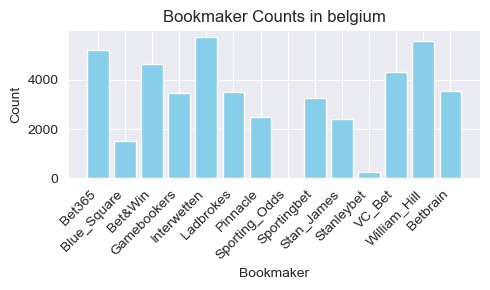

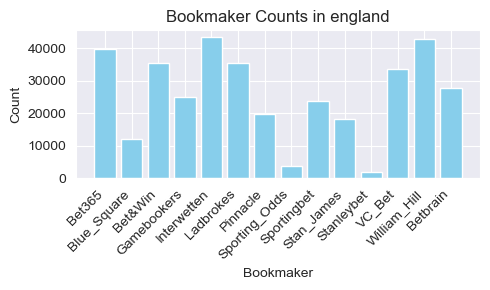

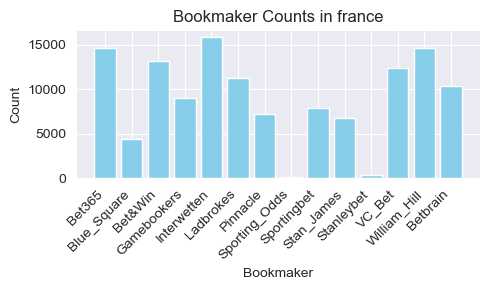

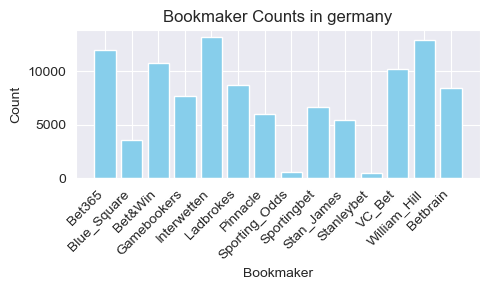

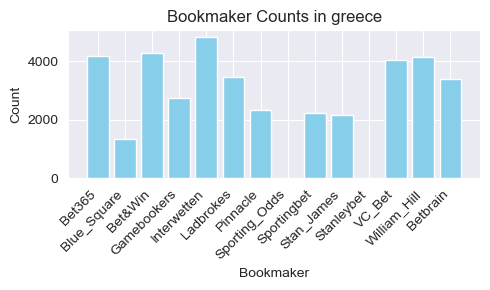

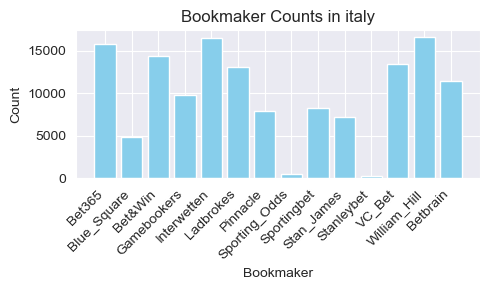

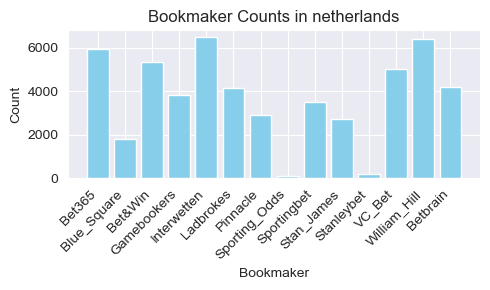

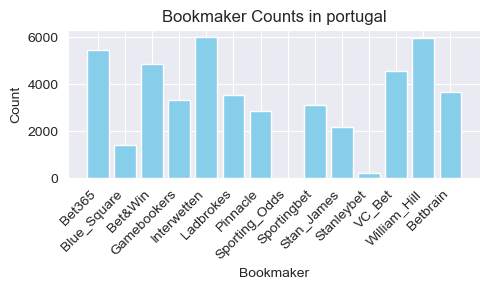

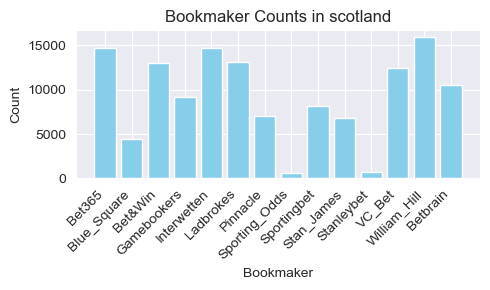

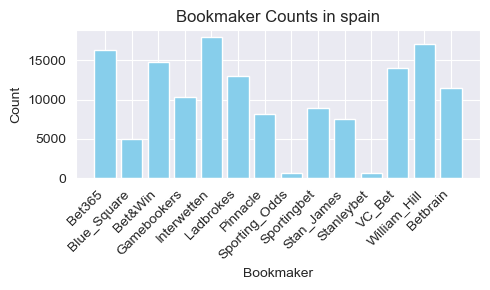

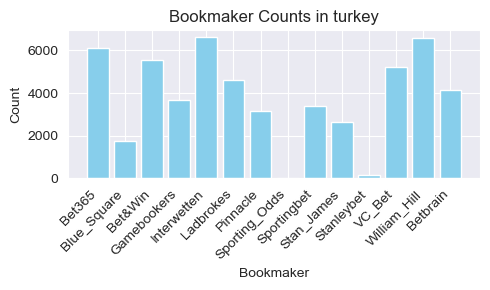

In [104]:
# Group by 'Country' and count the occurrences of 1 for each bookmaker
grouped_df = df_test.groupby('Country')[indicator_columns].sum().reset_index()

# Plot a bar chart for each country
for index, row in grouped_df.iterrows():
    country_name = row['Country']
    bookmaker_counts = row[indicator_columns].astype(int)
    bookmaker_name = [bkmkr.split('_indicator')[0] for bkmkr in indicator_columns]

    plt.figure(figsize=(5, 3))
    plt.bar(bookmaker_name, bookmaker_counts, color='skyblue')
    plt.title(f'Bookmaker Counts in {country_name}')
    plt.xlabel('Bookmaker')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.show()

There is no significant difference in bet distribution between the bookmakers per country.

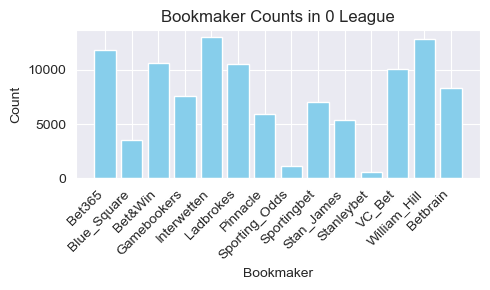

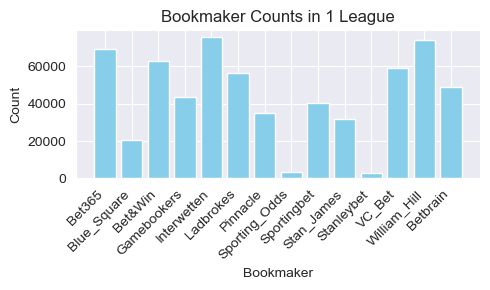

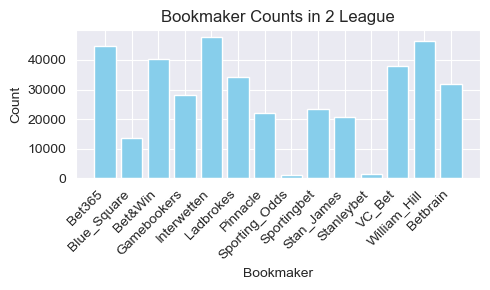

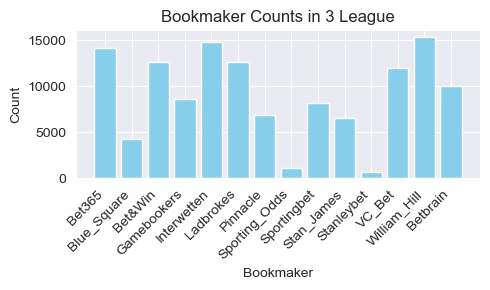

In [105]:
# Group by 'League' and count the occurrences of 1 for each bookmaker
grouped_df = df_test.groupby('League')[indicator_columns].sum().reset_index()

# Plot a bar chart for each league
for index, row in grouped_df.iterrows():
    league_name = row['League']
    bookmaker_counts = row[indicator_columns].astype(int)
    bookmaker_name = [bkmkr.split('_indicator')[0] for bkmkr in indicator_columns]

    plt.figure(figsize=(5, 3))
    plt.bar(bookmaker_name, bookmaker_counts, color='skyblue')
    plt.title(f'Bookmaker Counts in {league_name} League')
    plt.xlabel('Bookmaker')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.show()

There is no significant difference in bet distribution between the bookmakers per league.

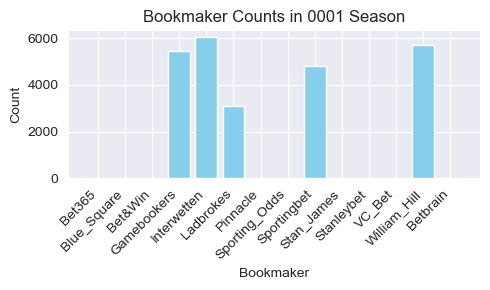

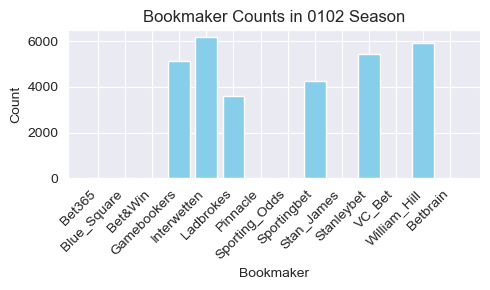

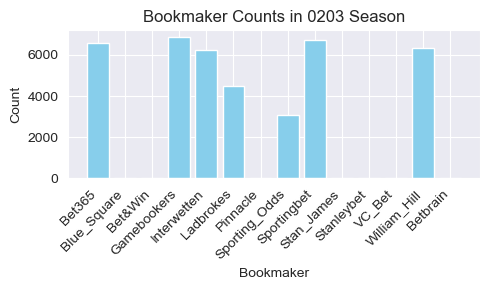

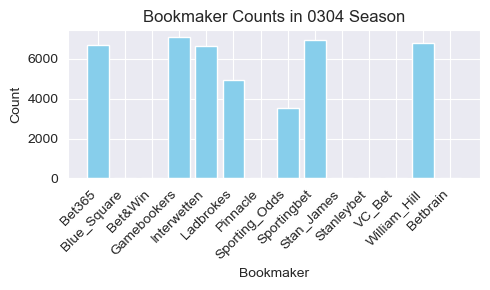

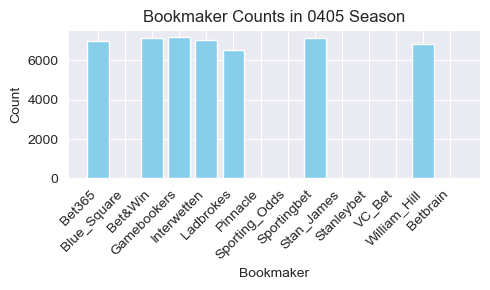

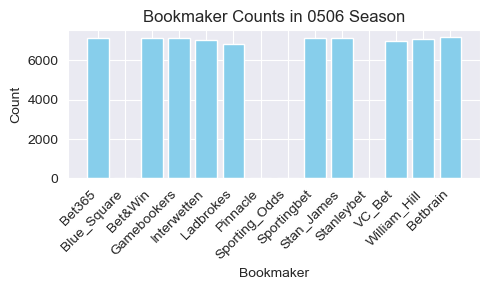

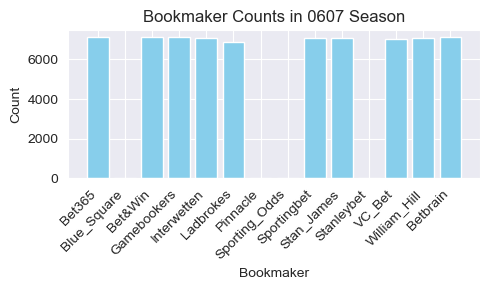

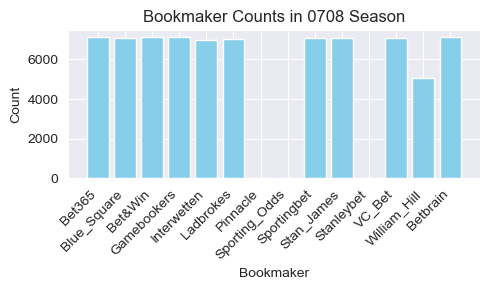

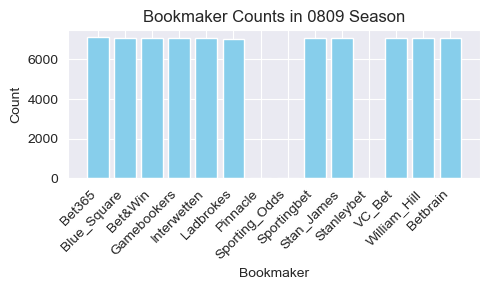

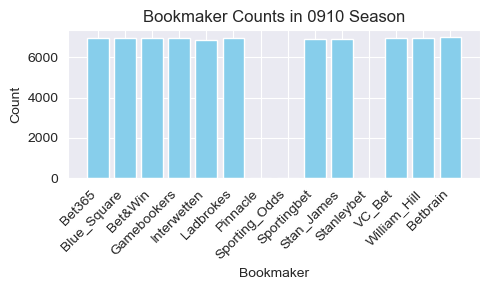

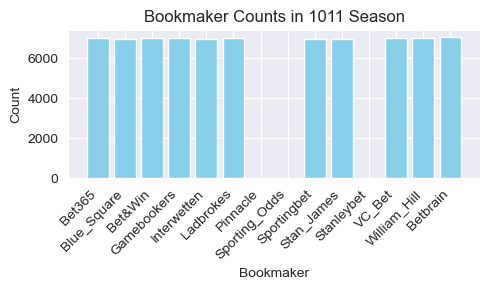

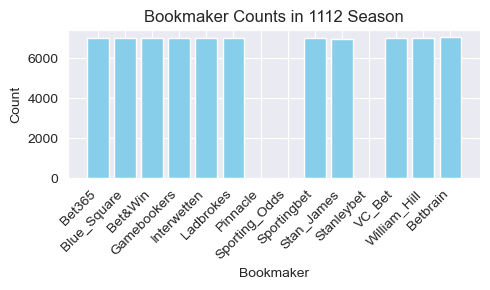

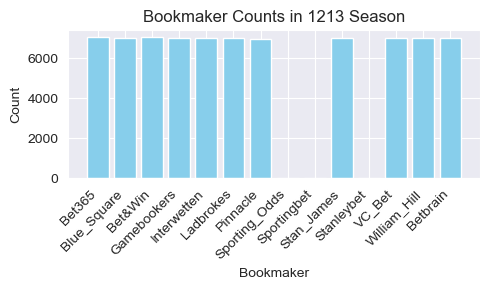

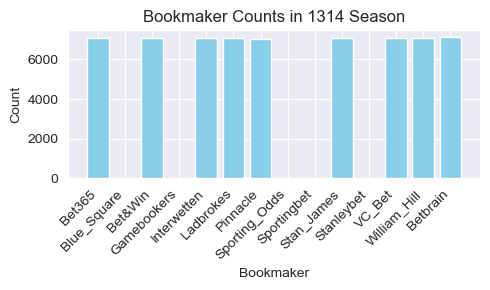

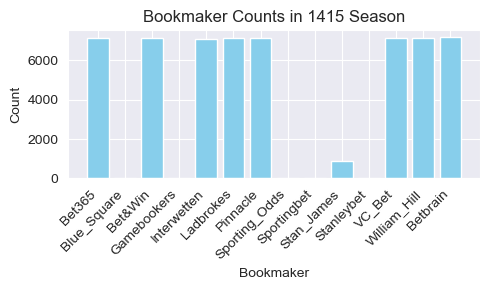

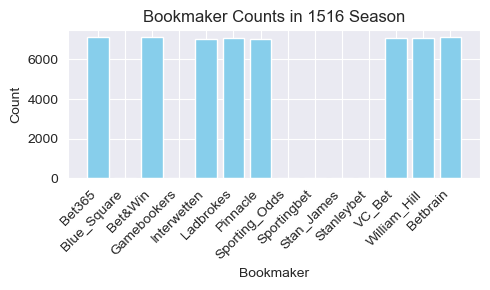

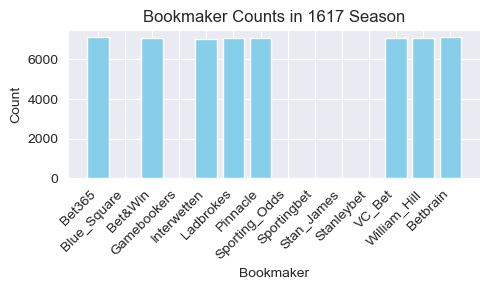

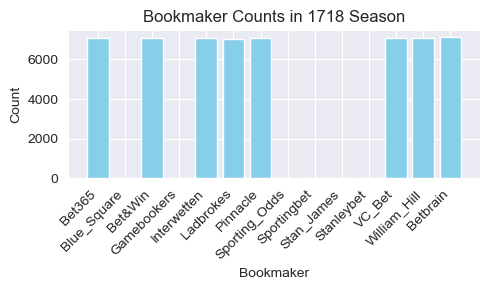

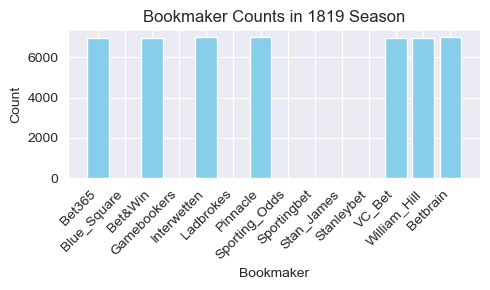

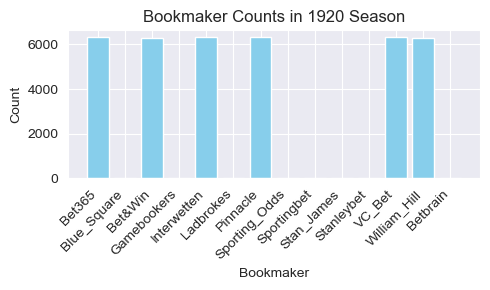

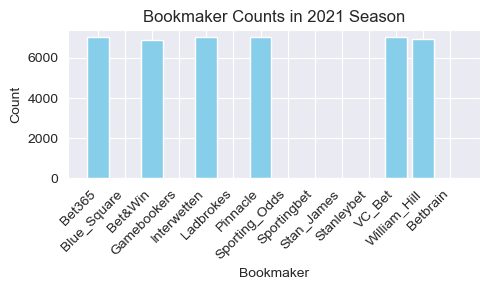

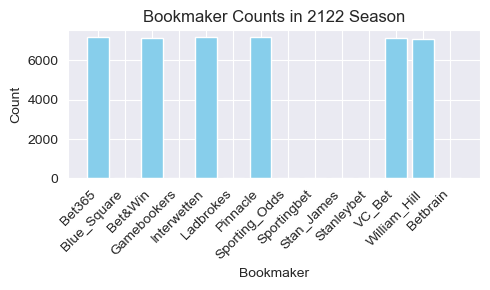

In [106]:
# Group by 'Season' and count the occurrences of 1 for each bookmaker
grouped_df = df_test.groupby('Season')[indicator_columns].sum().reset_index()

# Plot a bar chart for each league
for index, row in grouped_df.iterrows():
    league_name = row['Season']
    bookmaker_counts = row[indicator_columns].astype(int)
    bookmaker_name = [bkmkr.split('_indicator')[0] for bkmkr in indicator_columns]

    plt.figure(figsize=(5, 3))
    plt.bar(bookmaker_name, bookmaker_counts, color='skyblue')
    plt.title(f'Bookmaker Counts in {league_name} Season')
    plt.xlabel('Bookmaker')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.show()

## NAs treatment

In [107]:
train_df.describe()

,Full_Time_Home_Team_Goals,Full_Time_Away_Team_Goals,Half_Time_Home_Team_Goals,Half_Time_Away_Team_Goals,Gamebookers_home_win_odds,Gamebookers_draw_odds,Gamebookers_away_win_odds,Interwetten_home_win_odds,Interwetten_draw_odds,Interwetten_away_win_odds,...,Home_Team_Offsides,Away_Team_Offsides,Home_Team_Bookings_Points,Away_Team_Bookings_Points,Sporting_Odds_home_win_odds,Sporting_Odds_draw_odds,Sporting_Odds_away_win_odds,Ladbrokes_Asian_handicap_home_team_odds,Ladbrokes_Asian_handicap_away_team_odds,Ladbrokes_size_of_handicap_home_team
count,154864.000000,154841.000000,154813.000000,154820.000000,88060.000000,88123.000000,88106.000000,150729.000000,150735.000000,150766.000000,...,6520.000000,6499.000000,6687.000000,6671.000000,6599.000000,6613.000000,6614.000000,5470.000000,5470.000000,5458.000000
mean,2.216358,1.130883,0.655636,0.494206,2.275366,3.381363,3.950892,2.335784,3.382514,3.753866,...,3.262423,3.250346,15.494990,20.914406,2.216488,3.391382,3.833776,1.911200,1.924793,-0.350500
std,21.861876,1.108967,0.809382,0.708167,1.039952,0.613622,2.195107,1.155085,0.713629,2.251540,...,2.371017,2.516174,14.985842,17.212936,0.983779,0.481409,2.078919,0.174042,0.124442,0.588259
min,0.000000,-1.000000,0.000000,0.000000,1.030000,1.250000,1.030000,1.010000,1.500000,1.030000,...,0.000000,0.000000,0.000000,0.000000,1.060000,2.380000,1.140000,-2.250000,-0.500000,-2.250000
25%,1.000000,0.000000,0.000000,0.000000,1.730000,3.100000,2.650000,1.750000,3.050000,2.550000,...,2.000000,1.000000,0.000000,10.000000,1.700000,3.200000,2.620000,1.840000,1.840000,-0.750000
50%,1.000000,1.000000,0.000000,0.000000,2.100000,3.250000,3.350000,2.100000,3.200000,3.200000,...,3.000000,3.000000,10.000000,20.000000,2.100000,3.250000,3.250000,1.920000,1.920000,-0.250000
75%,2.000000,2.000000,1.000000,1.000000,2.450000,3.450000,4.500000,2.500000,3.450000,4.200000,...,5.000000,5.000000,20.000000,30.000000,2.400000,3.400000,4.500000,2.000000,2.000000,0.000000
max,998.000000,13.000000,7.000000,6.000000,24.000000,11.000000,34.000000,30.000000,16.000000,70.000000,...,16.000000,18.000000,115.000000,150.000000,13.000000,8.000000,21.000000,3.400000,4.000000,9.000000


In [108]:
train_df.isna().sum()

Country                                         0
League                                          0
Season                                          0
League_Division                               311
Match_Date                                    367
                                            ...  
Sporting_Odds_draw_odds                    148560
Sporting_Odds_away_win_odds                148559
Ladbrokes_Asian_handicap_home_team_odds    149703
Ladbrokes_Asian_handicap_away_team_odds    149703
Ladbrokes_size_of_handicap_home_team       149715
Length: 168, dtype: int64

Dropping rows with missing values of our target variable and main indicators as long as they have less than 1% missing data.

In [109]:
# Remove rows 
train_df = train_df.dropna(subset=['Full_Time_Result', 'Home_Team', 'Away_Team', 'Full_Time_Home_Team_Goals', 'Full_Time_Away_Team_Goals', 'Half_Time_Home_Team_Goals', 'Half_Time_Away_Team_Goals', 'Half_Time_Result'])

# check how many rows we have left after this operation
remaining_rows = train_df.shape[0]
print(remaining_rows)


154262


In [110]:
train_df_old = train_df.copy()

## Imputing missing match statistics values

In [111]:
# Identify the columns for match statistics
match_stats_columns = [
    'Home_Team_Shots', 'Away_Team_Shots', 
    'Home_Team_Shots_on_Target', 'Away_Team_Shots_on_Target', 
    'Home_Team_Corners', 'Away_Team_Corners', 
    'Home_Team_Yellow_Cards', 'Away_Team_Yellow_Cards',
    'Home_Team_Red_Cards', 'Away_Team_Red_Cards',
    'Home_Team_Fouls_Committed', 'Away_Team_Fouls_Committed',
    # Add any other relevant columns here
]
train_df[match_stats_columns].describe()

#for column in match_stats_columns:
    #plt.figure(figsize=(10, 4))
    #sns.histplot(train_df[column], kde=True)
    #plt.title(f'Distribution of {column}')
    #plt.show()'''

,Home_Team_Shots,Away_Team_Shots,Home_Team_Shots_on_Target,Away_Team_Shots_on_Target,Home_Team_Corners,Away_Team_Corners,Home_Team_Yellow_Cards,Away_Team_Yellow_Cards,Home_Team_Red_Cards,Away_Team_Red_Cards,Home_Team_Fouls_Committed,Away_Team_Fouls_Committed
count,91930.000000,91975.000000,91017.000000,91044.000000,91522.000000,91574.000000,92123.000000,92121.000000,92144.000000,92088.000000,89893.000000,89902.000000
mean,12.674502,10.296178,5.231232,4.208877,5.722559,4.647291,1.642663,1.960400,0.087103,0.119929,12.848442,13.340793
std,4.925064,4.383924,2.808099,2.456535,2.937115,2.623584,1.292940,1.365013,0.299639,0.351746,4.555581,4.628635
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,7.000000,3.000000,2.000000,4.000000,3.000000,1.000000,1.000000,0.000000,0.000000,10.000000,10.000000
50%,12.000000,10.000000,5.000000,4.000000,5.000000,4.000000,1.000000,2.000000,0.000000,0.000000,12.000000,13.000000
75%,16.000000,13.000000,7.000000,6.000000,7.000000,6.000000,2.000000,3.000000,0.000000,0.000000,16.000000,16.000000
max,46.000000,45.000000,27.000000,23.000000,26.000000,21.000000,11.000000,10.000000,3.000000,9.000000,145.000000,77.000000


### Checking if data is missing at random or not

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

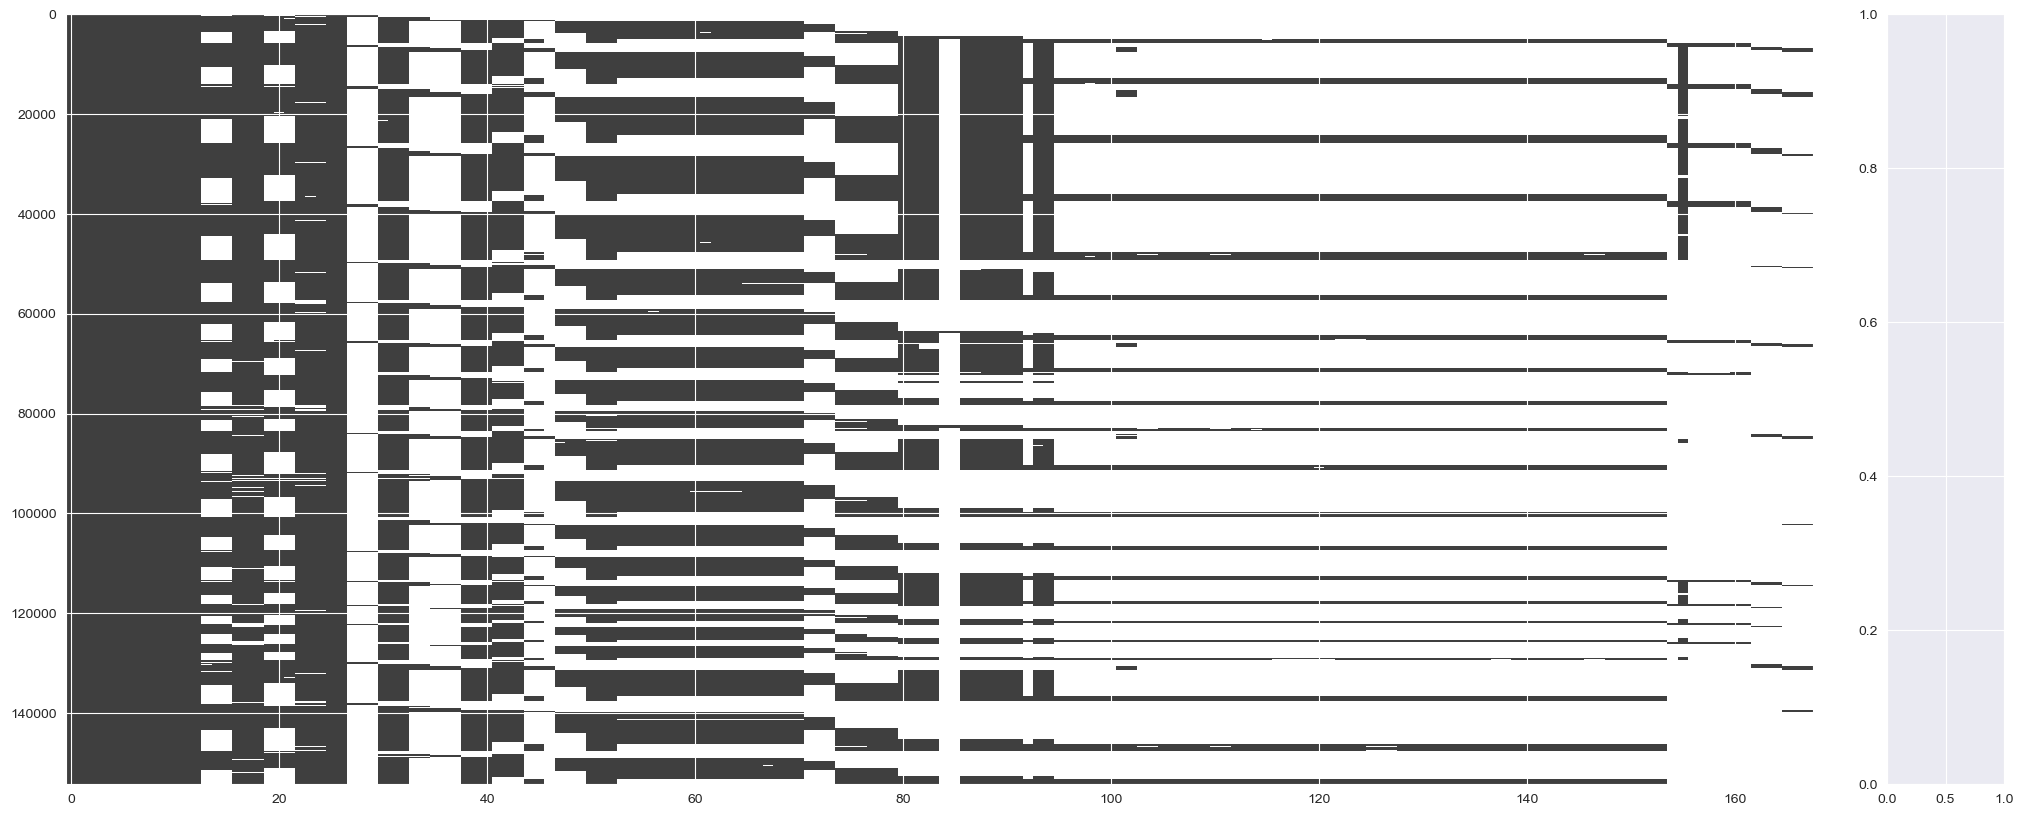

In [118]:
# Visualize the missingness pattern using missingno
msno.matrix(train_df)
plt.show()

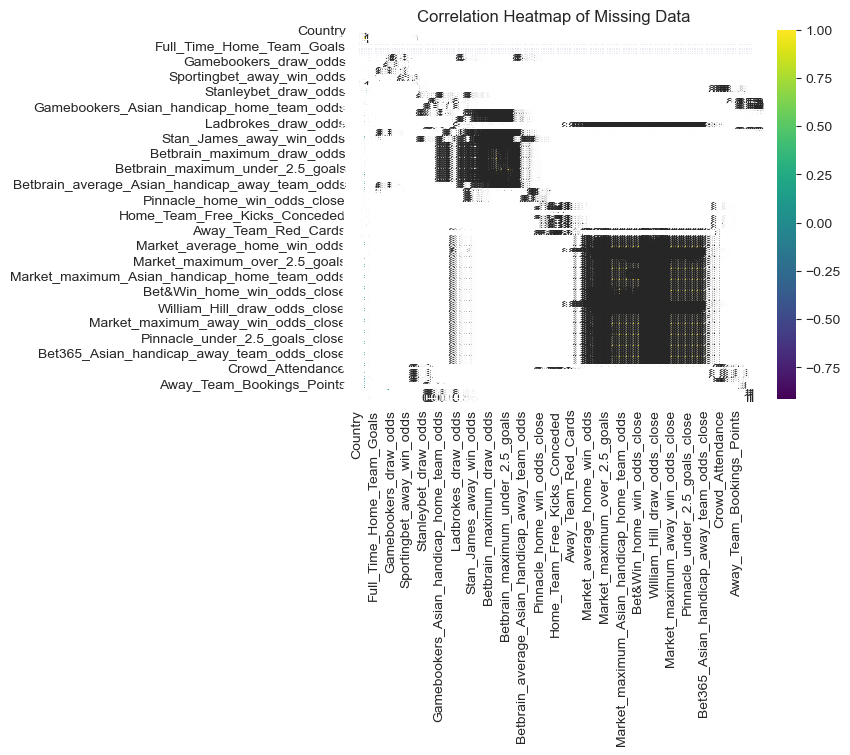

In [117]:
# Create a missingness indicator DataFrame
missing_indicator = train_df.isna()

# Heatmap of missingness correlation using standard correlation
sns.heatmap(missing_indicator.corr(), cmap='viridis', annot=True, linewidths=.5)
plt.title("Correlation Heatmap of Missing Data")
plt.show()

In [119]:
# Complex Impputation
# # Create a subset DataFrame with only the match statistics columns
# subset_df = train_df[match_stats_columns]
# 
# # Initialize the IterativeImputer
# iterative_imputer = IterativeImputer(max_iter=10, random_state=0)
# 
# # Fit the imputer on your subset and transform it
# subset_df_imputed = iterative_imputer.fit_transform(subset_df)
# 
# # Create a DataFrame from the imputed subset data
# subset_df_imputed = pd.DataFrame(subset_df_imputed, columns=subset_df.columns)
# 
# # Check the result
# print(pd.DataFrame(subset_df_imputed, columns=match_stats_columns).isna().sum())

In [120]:
# # Create a subset DataFrame with only the match statistics columns
# subset_df = train_df[match_stats_columns]
# 
# # Initialize the IterativeImputer with RandomForestRegressor as the estimator
# rf_imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10), max_iter=10, random_state=0)
# 
# # Fit the imputer on your subset and transform it
# subset_df_imputed_rf = rf_imputer.fit_transform(subset_df)
# 
# # Create a DataFrame from the imputed subset data
# subset_df_imputed_rf = pd.DataFrame(subset_df_imputed_rf, columns=subset_df.columns)
# 
# # Check the result
# print(subset_df_imputed_rf.isna().sum())

In [121]:
# Summary statistics for the original data
train_df_old[match_stats_columns].describe()

,Home_Team_Shots,Away_Team_Shots,Home_Team_Shots_on_Target,Away_Team_Shots_on_Target,Home_Team_Corners,Away_Team_Corners,Home_Team_Yellow_Cards,Away_Team_Yellow_Cards,Home_Team_Red_Cards,Away_Team_Red_Cards,Home_Team_Fouls_Committed,Away_Team_Fouls_Committed
count,91930.000000,91975.000000,91017.000000,91044.000000,91522.000000,91574.000000,92123.000000,92121.000000,92144.000000,92088.000000,89893.000000,89902.000000
mean,12.674502,10.296178,5.231232,4.208877,5.722559,4.647291,1.642663,1.960400,0.087103,0.119929,12.848442,13.340793
std,4.925064,4.383924,2.808099,2.456535,2.937115,2.623584,1.292940,1.365013,0.299639,0.351746,4.555581,4.628635
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,7.000000,3.000000,2.000000,4.000000,3.000000,1.000000,1.000000,0.000000,0.000000,10.000000,10.000000
50%,12.000000,10.000000,5.000000,4.000000,5.000000,4.000000,1.000000,2.000000,0.000000,0.000000,12.000000,13.000000
75%,16.000000,13.000000,7.000000,6.000000,7.000000,6.000000,2.000000,3.000000,0.000000,0.000000,16.000000,16.000000
max,46.000000,45.000000,27.000000,23.000000,26.000000,21.000000,11.000000,10.000000,3.000000,9.000000,145.000000,77.000000


In [122]:
# Summary statistics for the first imputation
# subset_df_imputed.describe()

In [123]:
# Summary statistics for the RandomForest imputation
# subset_df_imputed_rf.describe()

In [124]:
# Summary statistics for the original data
original_stats = train_df_old[match_stats_columns].describe()
# # Summary statistics for the first imputation
# first_impute_stats = subset_df_imputed.describe()
# # Summary statistics for the RandomForest imputation
# rf_impute_stats = subset_df_imputed_rf.describe()

In [125]:
# Histograms for each variable
# for column in match_stats_columns:
#     plt.figure(figsize=(12, 6))
#     plt.hist(train_df_old[column].dropna(), alpha=0.5, label='Original')
#     plt.hist(subset_df_imputed[column], alpha=0.5, label='First Imputation')
#     plt.hist(subset_df_imputed_rf[column], alpha=0.5, label='RF Imputation')
#     plt.title(f'Distribution for {column}')
#     plt.legend()
#     plt.show()

In [126]:
# Mean imputation
'''
mean_imputer = SimpleImputer(strategy='mean')
columns_for_mean_imputation = ['Home_Team_Shots', 'Away_Team_Shots', 
                               'Home_Team_Shots_on_Target', 'Away_Team_Shots_on_Target',
                               'Home_Team_Corners', 'Away_Team_Corners']

train_df[columns_for_mean_imputation] = mean_imputer.fit_transform(train_df[columns_for_mean_imputation])

# Median imputation
median_imputer = SimpleImputer(strategy='median')
columns_for_median_imputation = ['Home_Team_Yellow_Cards', 'Away_Team_Yellow_Cards',
                                 'Home_Team_Red_Cards', 'Away_Team_Red_Cards',
                                 'Home_Team_Fouls_Committed', 'Away_Team_Fouls_Committed']

train_df[columns_for_median_imputation] = median_imputer.fit_transform(train_df[columns_for_median_imputation])

# Check the result
print(train_df[match_stats_columns].isna().sum())'''

"\nmean_imputer = SimpleImputer(strategy='mean')\ncolumns_for_mean_imputation = ['Home_Team_Shots', 'Away_Team_Shots', \n                               'Home_Team_Shots_on_Target', 'Away_Team_Shots_on_Target',\n                               'Home_Team_Corners', 'Away_Team_Corners']\n\ntrain_df[columns_for_mean_imputation] = mean_imputer.fit_transform(train_df[columns_for_mean_imputation])\n\n# Median imputation\nmedian_imputer = SimpleImputer(strategy='median')\ncolumns_for_median_imputation = ['Home_Team_Yellow_Cards', 'Away_Team_Yellow_Cards',\n                                 'Home_Team_Red_Cards', 'Away_Team_Red_Cards',\n                                 'Home_Team_Fouls_Committed', 'Away_Team_Fouls_Committed']\n\ntrain_df[columns_for_median_imputation] = median_imputer.fit_transform(train_df[columns_for_median_imputation])\n\n# Check the result\nprint(train_df[match_stats_columns].isna().sum())"

## Remove columns with excessive missingness

In [127]:
'''# Define a threshold for the maximum allowed proportion of missing values
threshold = 0.98

# Calculate the proportion of missing values for each column
missing_proportion = train_df.isna().sum() / len(train_df)

# Identify columns that have missing values above the threshold
columns_to_drop = missing_proportion[missing_proportion > threshold].index.tolist()

# Drop these columns from the DataFrame
train_df = train_df.drop(columns=columns_to_drop)

# Display the columns that have been dropped
print(f"Columns dropped: {columns_to_drop}")'''


'# Define a threshold for the maximum allowed proportion of missing values\nthreshold = 0.98\n\n# Calculate the proportion of missing values for each column\nmissing_proportion = train_df.isna().sum() / len(train_df)\n\n# Identify columns that have missing values above the threshold\ncolumns_to_drop = missing_proportion[missing_proportion > threshold].index.tolist()\n\n# Drop these columns from the DataFrame\ntrain_df = train_df.drop(columns=columns_to_drop)\n\n# Display the columns that have been dropped\nprint(f"Columns dropped: {columns_to_drop}")'

## Bookmakers odds corelation


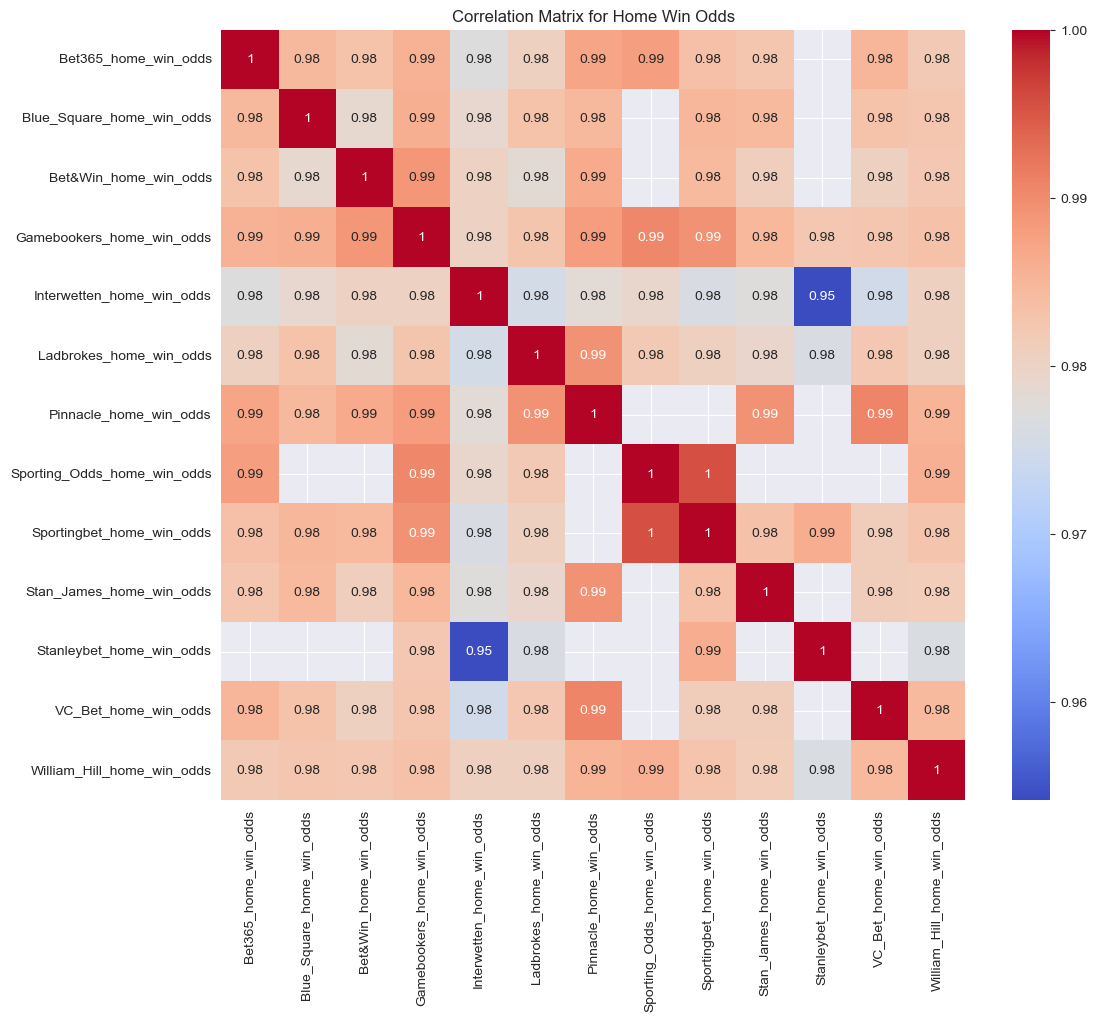

In [128]:

# Selecting home win odds from different bookmakers as an example
home_win_odds_columns = [
    "Bet365_home_win_odds", "Blue_Square_home_win_odds", "Bet&Win_home_win_odds",
    "Gamebookers_home_win_odds", "Interwetten_home_win_odds", "Ladbrokes_home_win_odds",
    "Pinnacle_home_win_odds", "Sporting_Odds_home_win_odds", "Sportingbet_home_win_odds",
    "Stan_James_home_win_odds", "Stanleybet_home_win_odds", "VC_Bet_home_win_odds",
    "William_Hill_home_win_odds"
]

# Compute the correlation matrix for home win odds
correlation_matrix_home_win = train_df[home_win_odds_columns].corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_home_win, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Home Win Odds')
plt.show()



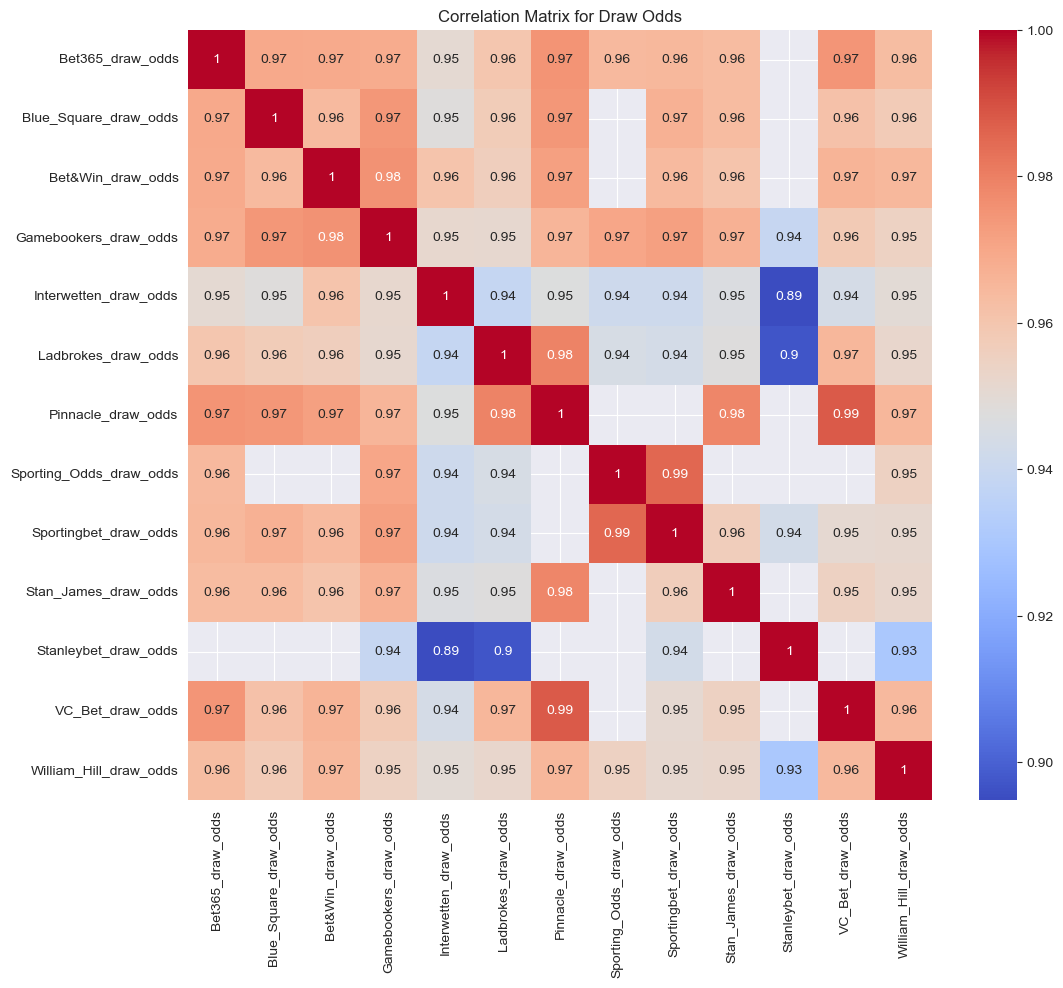

In [129]:
# Selecting draw odds from different bookmakers
draw_odds_columns = [
    "Bet365_draw_odds", "Blue_Square_draw_odds", "Bet&Win_draw_odds",
    "Gamebookers_draw_odds", "Interwetten_draw_odds", "Ladbrokes_draw_odds",
    "Pinnacle_draw_odds", "Sporting_Odds_draw_odds", "Sportingbet_draw_odds",
    "Stan_James_draw_odds", "Stanleybet_draw_odds", "VC_Bet_draw_odds",
    "William_Hill_draw_odds"
]

# Compute the correlation matrix for draw odds
correlation_matrix_draw = train_df[draw_odds_columns].corr()

# Generate a heatmap of the correlation matrix for draw odds
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_draw, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Draw Odds')
plt.show()


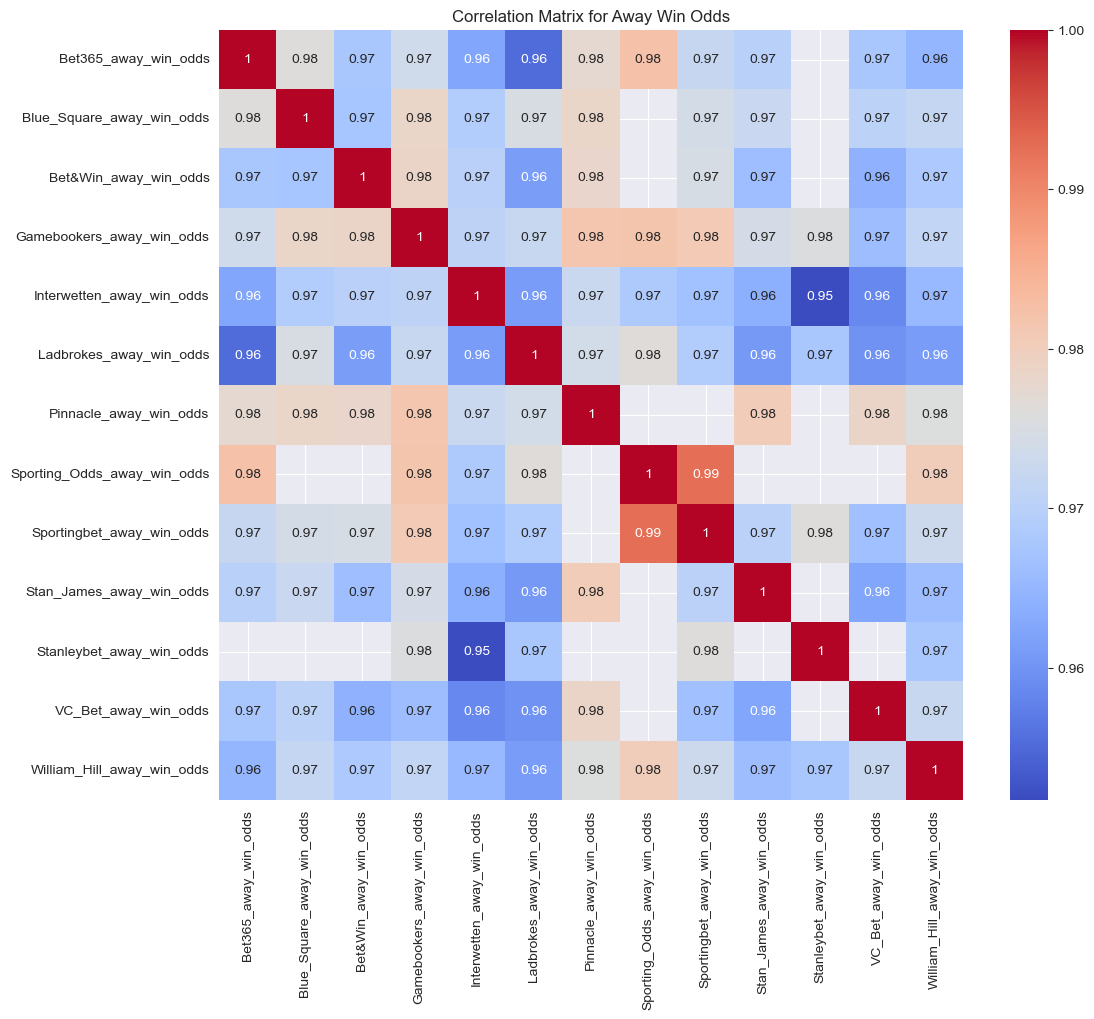

In [130]:
# Selecting away win odds from different bookmakers
away_win_odds_columns = [
    "Bet365_away_win_odds", "Blue_Square_away_win_odds", "Bet&Win_away_win_odds",
    "Gamebookers_away_win_odds", "Interwetten_away_win_odds", "Ladbrokes_away_win_odds",
    "Pinnacle_away_win_odds", "Sporting_Odds_away_win_odds", "Sportingbet_away_win_odds",
    "Stan_James_away_win_odds", "Stanleybet_away_win_odds", "VC_Bet_away_win_odds",
    "William_Hill_away_win_odds"
]

# Compute the correlation matrix for away win odds
correlation_matrix_away_win = train_df[away_win_odds_columns].corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_away_win, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Away Win Odds')
plt.show()


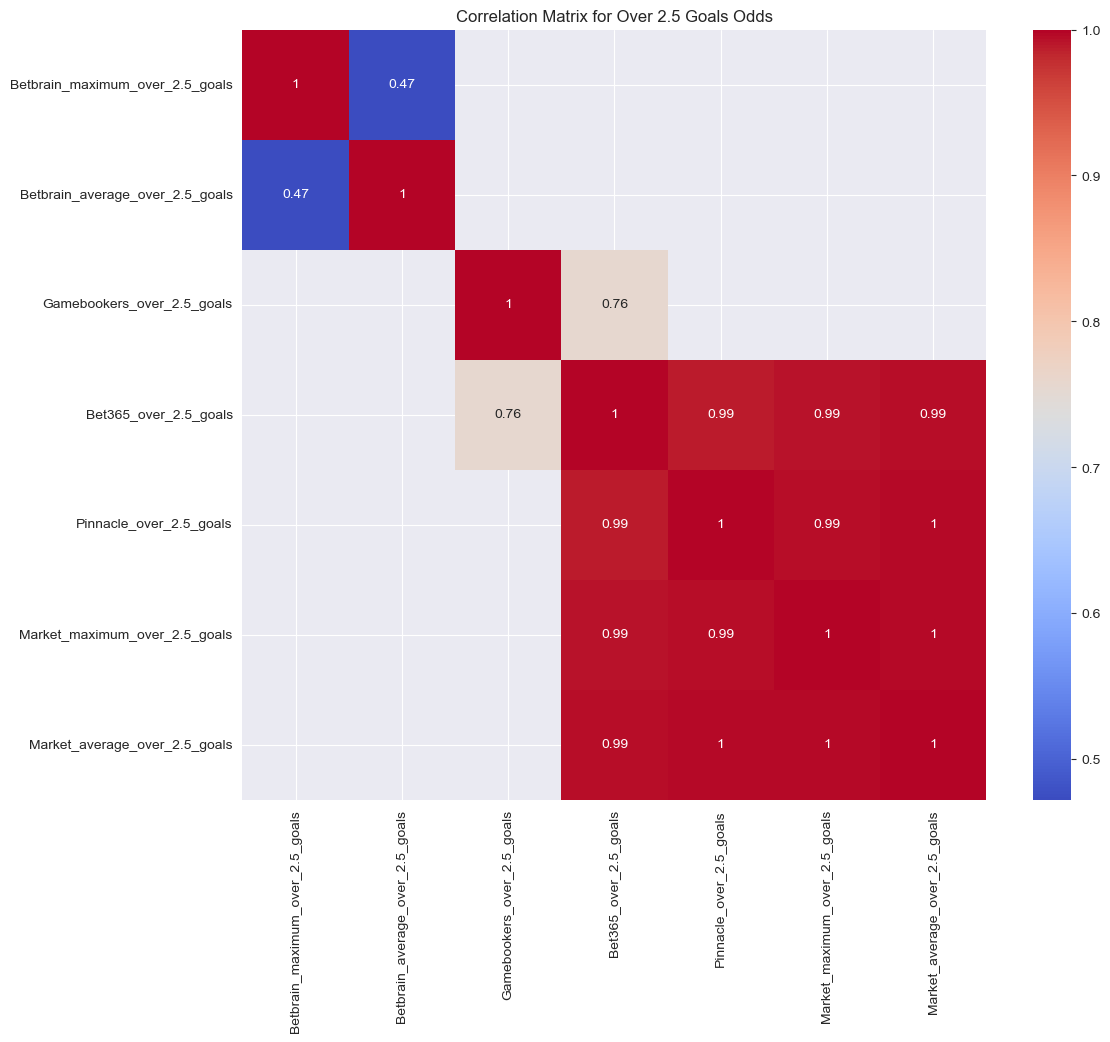

In [131]:
# Selecting over 2.5 goals odds from different bookmakers
over_2_5_goals_columns = [
    "Betbrain_maximum_over_2.5_goals", "Betbrain_average_over_2.5_goals",
    "Gamebookers_over_2.5_goals", "Bet365_over_2.5_goals",
    "Pinnacle_over_2.5_goals", "Market_maximum_over_2.5_goals",
    "Market_average_over_2.5_goals"
]

# Compute the correlation matrix for over 2.5 goals odds
correlation_matrix_over_2_5_goals = train_df[over_2_5_goals_columns].corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_over_2_5_goals, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Over 2.5 Goals Odds')
plt.show()


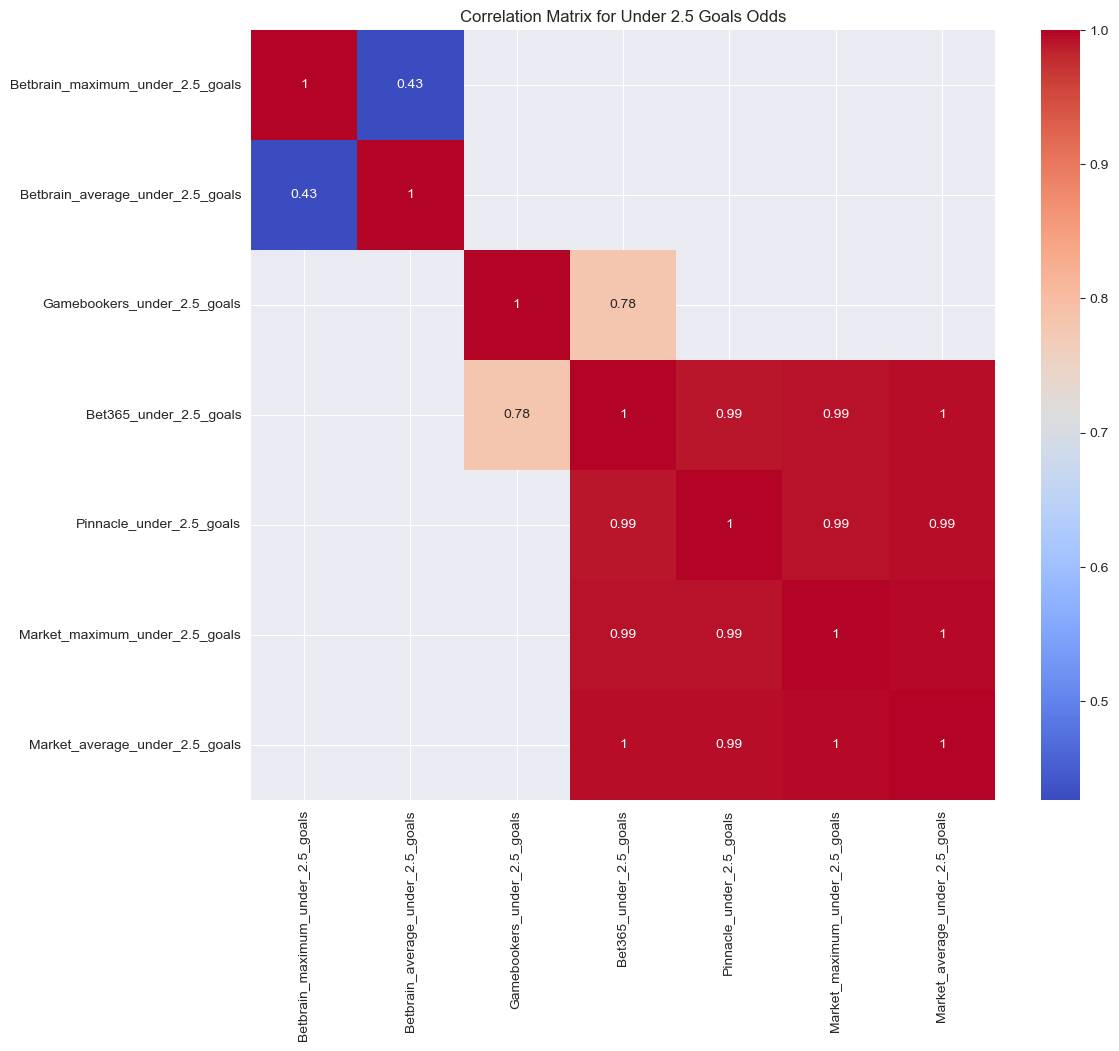

In [132]:
# Selecting under 2.5 goals odds from different bookmakers
under_2_5_goals_columns = [
    "Betbrain_maximum_under_2.5_goals", "Betbrain_average_under_2.5_goals",
    "Gamebookers_under_2.5_goals", "Bet365_under_2.5_goals",
    "Pinnacle_under_2.5_goals", "Market_maximum_under_2.5_goals",
    "Market_average_under_2.5_goals"
]

# Compute the correlation matrix for under 2.5 goals odds
correlation_matrix_under_2_5_goals = train_df[under_2_5_goals_columns].corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_under_2_5_goals, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Under 2.5 Goals Odds')
plt.show()


/var/folders/g3/b2rhcsbj74b0r5p3cjff117h0000gn/T/ipykernel_3317/2027020004.py:17: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix_asian_handicap = train_df[asian_handicap_columns].corr()


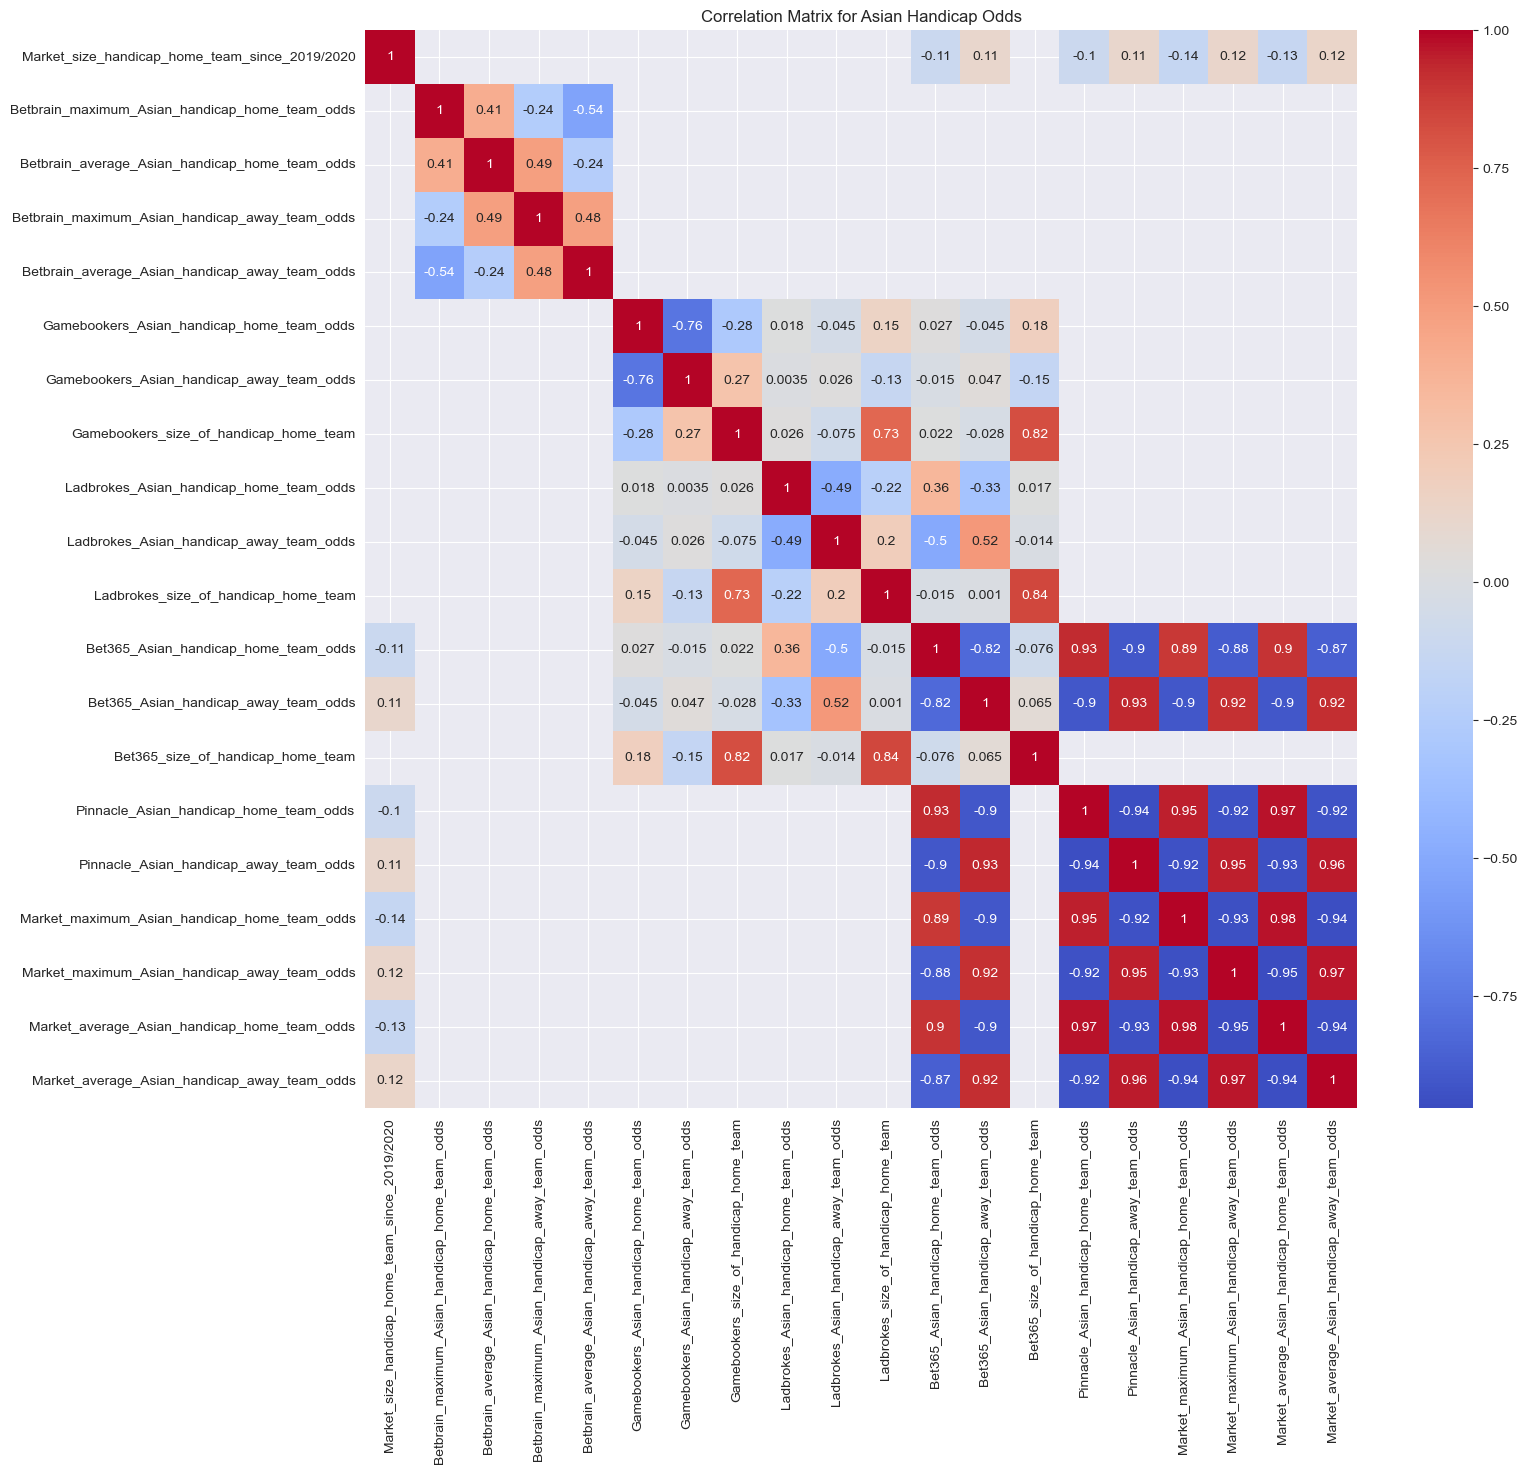

In [133]:
# Selecting Asian handicap odds from different bookmakers
asian_handicap_columns = [
    "Betbrain_size_of_handicap_home_team", "Market_size_handicap_home_team_since_2019/2020",
    "Betbrain_maximum_Asian_handicap_home_team_odds", "Betbrain_average_Asian_handicap_home_team_odds",
    "Betbrain_maximum_Asian_handicap_away_team_odds", "Betbrain_average_Asian_handicap_away_team_odds",
    "Gamebookers_Asian_handicap_home_team_odds", "Gamebookers_Asian_handicap_away_team_odds",
    "Gamebookers_size_of_handicap_home_team", "Ladbrokes_Asian_handicap_home_team_odds",
    "Ladbrokes_Asian_handicap_away_team_odds", "Ladbrokes_size_of_handicap_home_team",
    "Bet365_Asian_handicap_home_team_odds", "Bet365_Asian_handicap_away_team_odds",
    "Bet365_size_of_handicap_home_team", "Pinnacle_Asian_handicap_home_team_odds",
    "Pinnacle_Asian_handicap_away_team_odds", "Market_maximum_Asian_handicap_home_team_odds",
    "Market_maximum_Asian_handicap_away_team_odds", "Market_average_Asian_handicap_home_team_odds",
    "Market_average_Asian_handicap_away_team_odds"
]

# Compute the correlation matrix for Asian handicap odds
correlation_matrix_asian_handicap = train_df[asian_handicap_columns].corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix_asian_handicap, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Asian Handicap Odds')
plt.show()


## Feature engineering

### Aggregated columns for bookmakers

In [134]:
# Define the columns for home win, away win, and draw odds
home_win_columns = [
    "Bet365_home_win_odds", "Blue_Square_home_win_odds", "Bet&Win_home_win_odds",
    "Gamebookers_home_win_odds", "Interwetten_home_win_odds", "Ladbrokes_home_win_odds",
    "Pinnacle_home_win_odds", "Sporting_Odds_home_win_odds", "Sportingbet_home_win_odds",
    "Stan_James_home_win_odds", "Stanleybet_home_win_odds", "VC_Bet_home_win_odds",
    "William_Hill_home_win_odds", "Betbrain_average_home_win_odds"
]

away_win_columns = [
    "Bet365_away_win_odds", "Blue_Square_away_win_odds", "Bet&Win_away_win_odds",
    "Gamebookers_away_win_odds", "Interwetten_away_win_odds", "Ladbrokes_away_win_odds",
    "Pinnacle_away_win_odds", "Sporting_Odds_away_win_odds", "Sportingbet_away_win_odds",
    "Stan_James_away_win_odds", "Stanleybet_away_win_odds", "VC_Bet_away_win_odds",
    "William_Hill_away_win_odds", "Betbrain_average_away_win_odds"
]

draw_columns = [
    "Bet365_draw_odds", "Blue_Square_draw_odds", "Bet&Win_draw_odds",
    "Gamebookers_draw_odds", "Interwetten_draw_odds", "Ladbrokes_draw_odds",
    "Pinnacle_draw_odds", "Sporting_Odds_draw_odds", "Sportingbet_draw_odds",
    "Stan_James_draw_odds", "Stanleybet_draw_odds", "VC_Bet_draw_odds",
    "William_Hill_draw_odds", "Betbrain_average_draw_win_odds"
]

# Create new features for average home win, away win, and draw odds
train_df["Average_home_win_odds"] = train_df[home_win_columns].mean(axis=1, skipna=True)
train_df["Average_away_win_odds"] = train_df[away_win_columns].mean(axis=1, skipna=True)
train_df["Average_draw_odds"] = train_df[draw_columns].mean(axis=1, skipna=True)

# Display the updated DataFrame with new features
print(train_df.head())

   Country League Season League_Division Match_Date    Home_Team  Away_Team  \
0  belgium      1   0001              B1 2000-08-12     Mechelen       Genk   
1  belgium      1   0001              B1 2000-08-12     Mouscron   Germinal   
2  belgium      1   0001              B1 2000-08-12  Louvieroise    Lokeren   
3  belgium      1   0001              B1 2000-08-12     Westerlo    Antwerp   
4  belgium      1   0001              B1 2000-08-12      Beveren  Charleroi   

   Full_Time_Home_Team_Goals  Full_Time_Away_Team_Goals Full_Time_Result  ...  \
0                        0.0                        0.0                D  ...   
1                        3.0                        0.0                H  ...   
2                        0.0                        0.0                D  ...   
3                        2.0                        1.0                H  ...   
4                        1.0                        2.0                A  ...   

   Away_Team_Bookings_Points  Sporting

In [135]:
print("Missing values in Average_home_win_odds:", train_df['Average_home_win_odds'].isna().sum())
print("Missing values in Average_away_win_odds:", train_df['Average_away_win_odds'].isna().sum())
print("Missing values in Average_draw_odds:", train_df['Average_draw_odds'].isna().sum())

Missing values in Average_home_win_odds: 547
Missing values in Average_away_win_odds: 546
Missing values in Average_draw_odds: 547


In [136]:
# Drop the original bookmaker odds columns
train_df = train_df.drop(columns=betting_odds_1x2_match.values())

In [137]:
# Define the columns for over 2.5 goals odds
over_2_5_goals_columns = [
    "Betbrain_average_over_2.5_goals",
    "Gamebookers_over_2.5_goals", "Bet365_over_2.5_goals",
    "Pinnacle_over_2.5_goals", "Market_average_over_2.5_goals"
]

# Create new feature for average over 2.5 goals odds
train_df["Average_over_2.5_goals"] = train_df[over_2_5_goals_columns].mean(axis=1, skipna=True)

# Display the updated DataFrame with new feature
print(train_df.head())

   Country League Season League_Division Match_Date    Home_Team  Away_Team  \
0  belgium      1   0001              B1 2000-08-12     Mechelen       Genk   
1  belgium      1   0001              B1 2000-08-12     Mouscron   Germinal   
2  belgium      1   0001              B1 2000-08-12  Louvieroise    Lokeren   
3  belgium      1   0001              B1 2000-08-12     Westerlo    Antwerp   
4  belgium      1   0001              B1 2000-08-12      Beveren  Charleroi   

   Full_Time_Home_Team_Goals  Full_Time_Away_Team_Goals Full_Time_Result  ...  \
0                        0.0                        0.0                D  ...   
1                        3.0                        0.0                H  ...   
2                        0.0                        0.0                D  ...   
3                        2.0                        1.0                H  ...   
4                        1.0                        2.0                A  ...   

   Away_Team_Offsides  Home_Team_Booki

In [138]:
print("Missing values in Average_over_2.5_goals:", train_df['Average_over_2.5_goals'].isna().sum())

Missing values in Average_over_2.5_goals: 18505


In [139]:
# Define the columns for under 2.5 goals odds
under_2_5_goals_columns = [
    "Betbrain_average_under_2.5_goals",
    "Gamebookers_under_2.5_goals", "Bet365_under_2.5_goals",
    "Pinnacle_under_2.5_goals", "Market_average_under_2.5_goals"
]

# Create new feature for average under 2.5 goals odds
train_df["Average_under_2.5_goals"] = train_df[under_2_5_goals_columns].mean(axis=1, skipna=True)

# Display the updated DataFrame with new feature
print(train_df.head())


   Country League Season League_Division Match_Date    Home_Team  Away_Team  \
0  belgium      1   0001              B1 2000-08-12     Mechelen       Genk   
1  belgium      1   0001              B1 2000-08-12     Mouscron   Germinal   
2  belgium      1   0001              B1 2000-08-12  Louvieroise    Lokeren   
3  belgium      1   0001              B1 2000-08-12     Westerlo    Antwerp   
4  belgium      1   0001              B1 2000-08-12      Beveren  Charleroi   

   Full_Time_Home_Team_Goals  Full_Time_Away_Team_Goals Full_Time_Result  ...  \
0                        0.0                        0.0                D  ...   
1                        3.0                        0.0                H  ...   
2                        0.0                        0.0                D  ...   
3                        2.0                        1.0                H  ...   
4                        1.0                        2.0                A  ...   

   Home_Team_Bookings_Points  Away_Tea

In [140]:
print("Missing values in Average_under_2.5_goals:", train_df['Average_under_2.5_goals'].isna().sum())

Missing values in Average_under_2.5_goals: 18461


In [141]:
train_df = train_df.drop(columns=betting_odds_total_goals.values())

In [142]:
# Define the Asian handicap columns
asian_handicap_columns = betting_odds_asian_handicap.values()

# Split columns by home and away
home_asian_handicap = [
    col for col in asian_handicap_columns if ("home" in col.lower() and "maximum" not in col.lower())
]

away_asian_handicap = [
    col for col in asian_handicap_columns if ("away" in col.lower() and "maximum" not in col.lower())
]

# Create new features for average Asian handicap odds for home and away
train_df["Average_Asian_Handicap_Home"] = train_df[home_asian_handicap].mean(axis=1, skipna=True)
train_df["Average_Asian_Handicap_Away"] = train_df[away_asian_handicap].mean(axis=1, skipna=True)

# Display the updated DataFrame with new features
print(train_df.head())


   Country League Season League_Division Match_Date    Home_Team  Away_Team  \
0  belgium      1   0001              B1 2000-08-12     Mechelen       Genk   
1  belgium      1   0001              B1 2000-08-12     Mouscron   Germinal   
2  belgium      1   0001              B1 2000-08-12  Louvieroise    Lokeren   
3  belgium      1   0001              B1 2000-08-12     Westerlo    Antwerp   
4  belgium      1   0001              B1 2000-08-12      Beveren  Charleroi   

   Full_Time_Home_Team_Goals  Full_Time_Away_Team_Goals Full_Time_Result  ...  \
0                        0.0                        0.0                D  ...   
1                        3.0                        0.0                H  ...   
2                        0.0                        0.0                D  ...   
3                        2.0                        1.0                H  ...   
4                        1.0                        2.0                A  ...   

   Ladbrokes_Asian_handicap_home_team_

/var/folders/g3/b2rhcsbj74b0r5p3cjff117h0000gn/T/ipykernel_3317/375060694.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_df["Average_Asian_Handicap_Home"] = train_df[home_asian_handicap].mean(axis=1, skipna=True)


In [143]:
print("Missing values in Average_Asian_Handicap_Home:", train_df['Average_Asian_Handicap_Home'].isna().sum())
print("Missing values in Average_Asian_Handicap_Away:", train_df['Average_Asian_Handicap_Away'].isna().sum())

Missing values in Average_Asian_Handicap_Home: 23434
Missing values in Average_Asian_Handicap_Away: 23507


In [144]:
train_df = train_df.drop(columns=betting_odds_asian_handicap.values())

In [145]:
train_df[closing_odds.values()].isna().sum()

Market_size_handicap_home_team_since_2019/2020_close    133823
Average_under_2.5_goals_close                           133807
Average_over_2.5_goals_close                            133807
Away_win_odds_average_close                             133823
Asian_handicap_away_team_odds_average_close             133827
Asian_handicap_home_team_odds_average_close             133807
Draw_odds_average_close                                 133807
Home_win_odds_average_close                             133818
Bet365_under_2.5_goals_close                            133837
Bet365_over_2.5_goals_close                             133862
Bet365_away_win_odds_close                              133833
Bet365_Asian_handicap_away_team_odds_close              133857
Bet365_Asian_handicap_home_team_odds_close              133857
Bet365_draw_odds_close                                  133833
Bet365_home_win_odds_close                              133847
Bet&Win_away_win_odds_close                            

Most of the columns have more than 80% missing values, so we will drop them.

In [146]:
train_df = train_df.drop(columns=closing_odds.values())

In [147]:
train_df.isna().sum()

Country                               0
League                                0
Season                                0
League_Division                      90
Match_Date                          146
Home_Team                             0
Away_Team                             0
Full_Time_Home_Team_Goals             0
Full_Time_Away_Team_Goals             0
Full_Time_Result                      0
Half_Time_Home_Team_Goals             0
Half_Time_Away_Team_Goals             0
Half_Time_Result                      0
DayOfWeek                           146
Weekend                               0
Home_Team_Shots                   62332
Away_Team_Shots                   62287
Home_Team_Shots_on_Target         63245
Away_Team_Shots_on_Target         63218
Home_Team_Free_Kicks_Conceded    152963
Away_Team_Free_Kicks_Conceded    152963
Home_Team_Corners                 62740
Away_Team_Corners                 62688
Home_Team_Yellow_Cards            62139
Away_Team_Yellow_Cards            62141


In [ ]:
train_df = train_df.drop(columns=['Home_Team_Free_Kicks_Conceded', 'Away_Team_Free_Kicks_Conceded', 'Time_of_match_kick_off'])